# Boilerplate code

## Let called libraries be reloaded in the notebook

In [1]:
%load_ext autoreload
%autoreload 2

## The default the libraries are loaded we need for the code.

In [2]:
from iterativenn.nn_modules.MaskedLinear import MaskedLinear
from iterativenn.nn_modules.HeterogeneousActivation import HeterogeneousActivation

from iterativenn.utils.DatasetUtils import ImageSequence

import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split

import pytorch_lightning as pl

# Parameters

In [3]:
train_size = 1000
validation_size = 100
# CUDA is broken at the moment.  Wrapping the Lit... class seems to confuse pytorch
#use_cuda=True
use_cuda=False
#max_epochs=20
max_epochs=2
batch_size=64
run_type='description'

# Data loading 

This likely needs to be refactored.  Having each training instance only have one data item is likely very slow.  Now, how one makes this play nice with the fact that not all sequences are the same length is an open question :-)

In [4]:
# The default collate_fn trys to do smart things about combining a minibatch into a single
# matrix.  This is likely not what we want in this general case, though there are things we can 
# learn from what other people do.  For example,
#
# https://androidkt.com/create-dataloader-with-collate_fn-for-variable-length-input-in-pytorch/
#
# talks about all of this in some detail, in the case of NLP.  The idea is that variable length data
# can be "zero padded", and there is even a pytorch helper function for this very case.
#
#  https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_sequence.html
#
# However, that seems like a bit overkill in our case at the moment, and there are several edge cases
# that we might need to consider, and just this simple fix gives us a 4-5 fold improvement in runtime.
# "premature optimization is the root of all evil"  :-) 
def trivial_collate_batch(batch):
  return batch

In [5]:
# data
dataset = MNIST('~/work/data', train=True, download=True, 
                transform=transforms.ToTensor())
mnist_train, mnist_val, _ = random_split(dataset, [train_size, validation_size, len(dataset)-(train_size+validation_size)])

# Turn the images into image sequences
mnist_train = ImageSequence(mnist_train, min_copies=2, max_copies=4)
mnist_val = ImageSequence(mnist_val, min_copies=2, max_copies=4)

# Note, these are the same as before, except that batch_size can be something other than one, and we just
# use the trivial collate function above.
train_loader = DataLoader(mnist_train, num_workers=2, batch_size=batch_size, collate_fn = trivial_collate_batch)
val_loader = DataLoader(mnist_val, num_workers=2, batch_size=batch_size, collate_fn = trivial_collate_batch)


This itself bears some reconsideration in the presence of the growing iterativenn.  I mean, the default now is that the end of the vector is the place where we evaluate the loss function, but for the growing model that makes less sense.

# The new implementation of the LitWrappedIterativeLinear model.

Note, the decisions here will affect the implementation of the LSTM wrapper.  Perhaps they should be combined into a single class?

In [6]:
import torch
import pytorch_lightning as pl
import torchmetrics

In [7]:
class LitWrappedIterativeLinear_v2(pl.LightningModule):
    """
    This implements a module which trains a MaskedLinear module.     
    Should be very simple.  Just give it a MaskedLinear module, and it will train it.
    """
    def __init__(self, wrappedModel):
        super().__init__()
        # The input class requires 4 methods
        # __call__(x, iteration):   x in an input element and i is the index of the input element in the input sequence
        # train_loss(y_true_list, y_list): y_true_list is a list of desired outputs and the y_list is a list of the produced outputs
        # validation_loss(y_true_list, y_list): y_true_list is a list of desired outputs and the y_list is a list of the produced outputs
        # predict(y): given a predictition from the model produce a "human readable" prediction. E.g., y might be a vector of likelihoods and
        #             predict of (y) could return the arg max of them.
        self.wrappedModel = wrappedModel
        # Note, pytorch lightning does smart things like looking at the 
        # instance variables of a class to find trainable parameters and put
        # data onto appropriate devices.  So, we need to have a reference to 
        # the model at the top-level of the class instance variables.
        self.model = wrappedModel.model

    def forward(self, x_and_y):
        x_sequence = x_and_y['x']
        
        # We only care about the output of the last iteration
        for i,x in enumerate(x_sequence[:-1]):
            _ = self.wrappedModel(x, i)
        y = self.wrappedModel(x_sequence[-1], len(x_sequence)-1)
        # NOTE:  This is only the final prediction, after seeing
        # the input sequence.  This is not the same as the loss which considers
        # intermediate predictions.
        return self.wrappedModel.predict(y)

    def configure_optimizers(self):
        # FIXME This model.model thing is not nice.  Fix!
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        return optimizer

    def _process_sequence(self, x_sequence, y_sequence):
        # The idea here is that x_sequence in a sequence of training examples, 
        # and is a y_sequence of desired responses at each time step.
        # Note, each of the training sequences might not
        # be the same length.
        # So, this loop goes over the "time" steps.
        # Questions that we need answered:
        # 1. Do we reinitialize after each sequence?  
        #    That will be handled by the initialization_func.
        y_truth_list = []
        y_output_list = []
        for i, (x, y) in enumerate(zip(x_sequence, y_sequence)):
            y_truth_list += [y]
            y_output_list += [self.wrappedModel(x, i)]
        return y_truth_list, y_output_list

    # When you call this, you will likely want to turn off
    # the automatic batching since the default collate_fn
    # raises errors with variable length image sequences    
    # https://pytorch.org/docs/stable/data.html
    # We instead use a trivial collate_fn that does
    # nothing with the batch.
    def training_step(self, train_item_batch, batch_idx):
        batch_loss = 0
        for train_item in train_item_batch:
            x_sequence, y_sequence = train_item['x'], train_item['y']
            y_truth_list, y_output_list = self._process_sequence(x_sequence, y_sequence)
            batch_loss += self.wrappedModel.train_loss(y_truth_list, y_output_list)
        average_batch_loss = batch_loss/len(train_item_batch)
        self.log('training_average_batch_loss', average_batch_loss, on_epoch=True)
        return average_batch_loss

    # when you call this, you will likely want to turn off
    # the automatic batching since the default collate_fn
    # raises errors with variable length image sequences    
    # https://pytorch.org/docs/stable/data.html
    def validation_step(self, val_item_batch, batch_idx):
        batch_loss = 0
        for val_item in val_item_batch:
            x_sequence, y_sequence = val_item['x'], val_item['y']
            y_truth_list, y_output_list = self._process_sequence(x_sequence, y_sequence)
            batch_loss += self.wrappedModel.validation_loss(y_truth_list, y_output_list)
        average_batch_loss = batch_loss/len(val_item_batch)
        self.log('validation_average_batch_loss', average_batch_loss, on_epoch=True)

    def number_of_trainable_parameters(self):
        return self.model.number_of_trainable_parameters()

# Actually getting things setup for the run

The loss needs to be rethought here.  Key principles:

1)  LitWrappedIterativeLinear only ever sees x and y, it knows nothing of z or h.
2)  ModelWithLoss handles given an x producing a y.
3)  h lives inside ModelWithLoss, and ModelWithLoss keeps track of the order in which __call__ is called.  I.e., it asserts if __call__(x,y,i+1) is called at any time except for right after __call__(x,y,i) 

In [8]:
# An example for an MLP
if run_type=='mlp':
    linear_map = MaskedLinear.from_MLP([784, 100, 10], compressed=True)
    activation = activation= HeterogeneousActivation([torch.nn.ReLU(), 
                                                    torch.nn.ReLU(), 
                                                    torch.nn.Identity()], 
                                                    [784, 100, 10])       
    model = torch.nn.Sequential(linear_map, activation)

    # z will always mean [x, h, y] or [x, y, h], depending on the model.
    class MLPWithLoss(object):
        def __init__(self, model):
            # The current state for the sequence
            self.model = model
            self.hy = None
            self.iteration = None

        def __call__(self, x, iteration):
            if iteration == 0:
                # Initialize internal state
                self.hy = torch.zeros(1, 110, device=x.device)
                self.iteration = 0
            else:
                self.iteration += 1
                assert iteration == self.iteration, f'Called out of order {iteration} {self.iteration}'

            # if so, then proceed with call
            #   concatenate x into z
            #   call model to produce h and y
            #   remember h (and train_loss(self, y_true_list, y_list):bit.  Other ways of doing this
            # lead to errors having to do with inplace 
            # modifications to a tensor from which we compute
            # gradients.
            z = torch.cat((x, self.hy), dim=1)
            z_out = self.model(z)
            self.hy = z_out[:,-110:]
            y = z_out[:,-10:]
            return y

        def train_loss(self, y_true_list, y_list):
            # Do whatever processing you want to produce the loss
            # between a list of truths and a list of predictions       
            # E.g., sum over all of the losses.
            loss_func = torch.nn.CrossEntropyLoss()
            # NOTE: This depends on only the last loss in the sequence.  This
            # makes sense for a "MLP"
            y_true = y_true_list[-1]
            y = y_list[-1]
            return loss_func(y, torch.tensor([y_true], device=y.device))

        def validation_loss(self, y_true_list, y_list):
            # Do whatever processing you want to produce the loss
            # between a list of truths and a list of predictions       
            # E.g., return just the last loss.
            loss_func = torch.nn.CrossEntropyLoss()
            y_true = y_true_list[-1]
            y = y_list[-1]
            return loss_func(y, torch.tensor([y_true], device=y.device))

        def predict(self, y):
            return int(y.argmax())


    wrappedModel = MLPWithLoss(model)

    lit_model = LitWrappedIterativeLinear_v2(wrappedModel)

In [10]:
# An example for a description
if run_type=='description':
    row_sizes = [100, 10]
    col_sizes = [784, 100, 10]
    block_types = [['R=0.5', 'S=5', 'Row=3'],
                   ['S=2', 'R=0.9', 'Row=1']]  
    initialization_types = [['G', 'G=0.2,0.7', 'U'],
                            ['U=-0.5,0.5', 1, torch.randn(size=(10, 10))]]
    trainable = [[1, 0, 1],
                 [1, 1, 1]]                         
    linear_map = MaskedLinear.from_description(row_sizes=row_sizes, 
                                                col_sizes=col_sizes,
                                                block_types=block_types,
                                                initialization_types=initialization_types,
                                                trainable=trainable)
    activation = activation= HeterogeneousActivation([torch.nn.ReLU(), 
                                                    torch.nn.ReLU(), 
                                                    torch.nn.Identity()], 
                                                    [784, 100, 10])       
    model = torch.nn.Sequential(linear_map, activation)

    # z will always mean [x, h, y] or [x, y, h], depending on the model.
    class DescriptionWithLoss(object):
        def __init__(self, model):
            # The current state for the sequence
            self.model = model
            self.hy = None
            self.iteration = None

        def __call__(self, x, iteration):
            if iteration == 0:
                # Initialize internal state
                self.hy = torch.zeros(1, 110, device=x.device)
                self.iteration = 0
            else:
                self.iteration += 1
                assert iteration == self.iteration, f'Called out of order {iteration} {self.iteration}'
            # if so, then proceed with call
            #   concatenate x into z
            #   call model to produce h and y
            #   remember h (and y if you want)
            #   return y

            # This should be somewhere else, like in the collate_fn?
            x = x.view(-1, 784)
            # This is a touchy bit.  Other ways of doing this
            # lead to errors having to do with inplace 
            # modifications to a tensor from which we compute
            # gradients.
            z = torch.cat((x, self.hy), dim=1)
            z_out = self.model(z)
            self.hy = z_out[:,-110:]
            y = z_out[:,-10:]
            return y

        def train_loss(self, y_true_list, y_list):
            # Do whatever processing you want to produce the loss
            # between a list of truths and a list of predictions       
            # E.g., sum over all of the losses.
            loss_func = torch.nn.CrossEntropyLoss()
            loss = 0
            # NOTE: This depends on all of the losses in the sequence.  This
            # makes sense for a "description"
            for y_true,y in zip(y_true_list, y_list):
                loss += loss_func(y, torch.tensor([y_true], device=y.device))
            return loss

        def validation_loss(self, y_true_list, y_list):
            # Do whatever processing you want to produce the loss
            # between a list of truths and a list of predictions       
            # E.g., return just the last loss.
            loss_func = torch.nn.CrossEntropyLoss()
            y_true = y_true_list[-1]
            y = y_list[-1]
            return loss_func(y, torch.tensor([y_true], device=y.device))

        def predict(self, y):
            return int(y.argmax())


    wrappedModel = DescriptionWithLoss(model)

    lit_model = LitWrappedIterativeLinear_v2(wrappedModel)

# Boilerplate code for doing the training

In [11]:
# It is interesting to note that on my laptop (2080 rtx and Ryzen 7 CPU), the GPU can be slower than the CPU.
if torch.cuda.is_available() and use_cuda:
    trainer = pl.Trainer(max_epochs=max_epochs,  
                         accelerator='gpu', devices=1)
else:
    trainer = pl.Trainer(max_epochs=max_epochs)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [12]:
weight_0_before = linear_map.weight_0.clone()
U_before = linear_map.U.clone().detach()

trainer.fit(lit_model, train_loader, val_loader)

weight_0_after = linear_map.weight_0.clone()
U_after = linear_map.U.clone().detach()


Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------

You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: /home/rcpaffenroth/projects/iterativenn/notebooks/lightning_logs
Missing logger folder: /home/rcpaffenroth/projects/iterativenn/notebooks/lightning_logs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 295 K 
-------------------------------------
98.5 K    Trainable params
196 K     Non-trainable params
295 K     Total params
1.181     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/rcpaffenroth/projects/iterativenn/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/rcpaffenroth/projects/iterativenn/venv/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/home/rcpaffenroth/projects/iterativenn/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:432: PossibleUserWarning: It is recommended to use `self.log('validation_average_batch_loss', ..., sync_dist=True)` when loggin

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/rcpaffenroth/projects/iterativenn/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:432: PossibleUserWarning: It is recommended to use `self.log('training_average_batch_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  warning_cache.warn(


Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


# Testing and visualization

In [13]:
import matplotlib.pylab as py
import numpy as np
%matplotlib inline

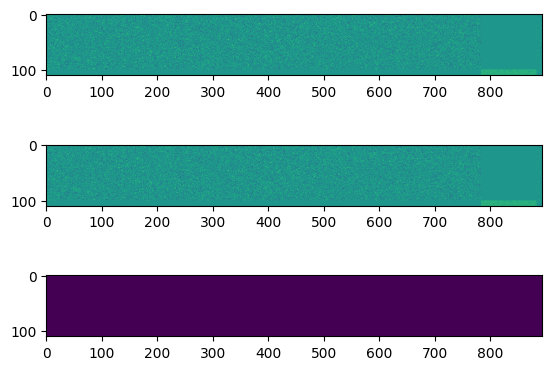

In [14]:
_, ax = py.subplots(3)
ax[0].imshow(weight_0_before)
ax[1].imshow(weight_0_after)
ax[2].imshow(weight_0_after-weight_0_before)


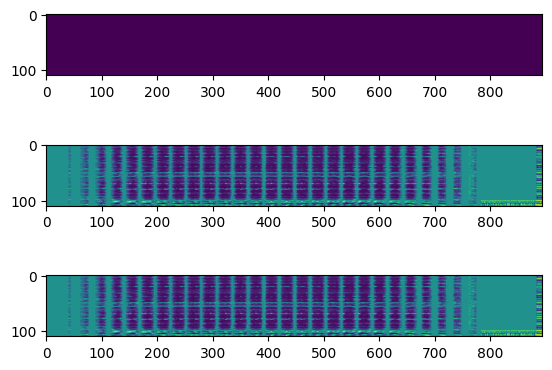

In [15]:
_, ax = py.subplots(3)    
ax[0].imshow(U_before)
ax[1].imshow(U_after)
ax[2].imshow(U_after-U_before)

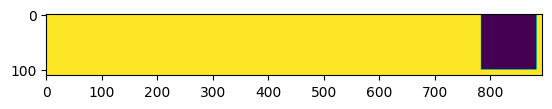

In [16]:
py.imshow(linear_map.mask)

In [17]:
np.min(np.array(linear_map.weight_0))

-4.4111953

In [18]:
np.max(np.array(linear_map.weight_0))

3.9938827

In [19]:
validation_data = list(iter(val_loader))[0]
x_sequence, y_sequence = validation_data[0]['x'], validation_data[0]['y']

0
0
0


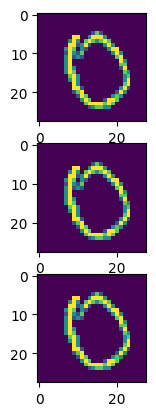

In [20]:
num_images = len(x_sequence)
_,ax = py.subplots(num_images, 1)
for i in range(num_images):
    ax[i].imshow(x_sequence[i][0,:,:])
    print(y_sequence[i])

In [21]:
for data in validation_data:
    truth = data['y'][0]
    prediction = lit_model.forward(data)
    print(f'{truth} {prediction}')

0 5
6 5
8 8
8 4
3 2
6 2
3 2
2 3
6 4
3 2
8 2
8 2
9 5
5 2
2 5
0 2
6 0
6 1
7 9
7 9
6 5
7 5
6 2
2 3
7 2
6 1
6 8
3 5
6 9
3 5
4 4
6 2
1 5
8 5
3 0
9 5
2 9
0 5
6 8
6 4
0 5
7 5
5 8
5 8
0 9
2 5
7 8
6 8
2 3
4 8
4 5
5 2
7 3
7 2
5 5
7 2
5 4
9 5
0 1
7 9
4 0
5 2
0 5
4 9
